# 回帰不連続デザイン  
---

シミュレーションデータを作成

高校の数学の授業で中間テストを行い、その点数が４０点（カットオフ値）未満の生徒には補講（トリートメント）を行った。  
期末テストの点数（結果変数）をみることで、補講の効果をみる  

In [1]:
import pandas as pd
import numpy as np

import rdrobust
import rddensity

import matplotlib.pyplot as plt


In [63]:
np.random.seed(77)

num_students = 200 #生徒の数

mid_score = np.random.uniform(0, 100, size=num_students).astype(int) #中間テストの点数（強制変数）
cutoff = 40 #カットオフ値

supp_class = [1 if score < cutoff else 0 for score in mid_score] #40点未満なら1を、そうでないなら0をとる


#真のモデル。補講は生徒の期末テストの点数を20点上げる
error = np.random.normal(0, 10, size=num_students) #誤差項
final_score = np.clip([mid + 20 * sup + int(e) for mid, sup, e in zip(mid_score,supp_class,error)], a_min=0,a_max=100)

In [64]:
df = pd.DataFrame({
    'mid_score': mid_score,
    'supp_class': supp_class,
    'final_score': final_score
})

df.head(10)

,mid_score,supp_class,final_score
0,91,0,100
1,64,0,82
2,75,0,74
3,13,1,36
4,8,1,27
5,78,0,80
6,32,1,53
7,54,0,64
8,24,1,45
9,54,0,74


#### 可視化

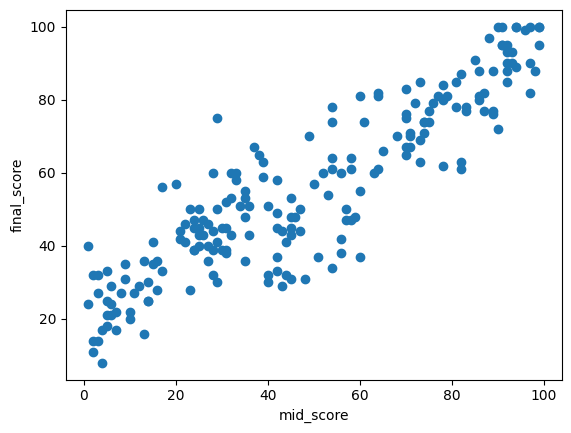

In [67]:
plt.scatter(data=df, x='mid_score', y='final_score')
plt.xlabel('mid_score')
plt.ylabel('final_score')
plt.show()

## 連続性の仮定の確認  
---

#### 1. カットオフ値付近の個体の分布を確認する  

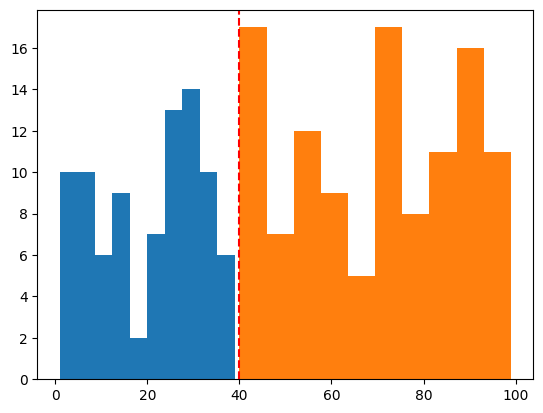

In [76]:
plt.hist(df[df['mid_score'] < cutoff]['mid_score'], bins=10, alpha=1.0, label='Below Cutoff')
plt.hist(df[df['mid_score'] >= cutoff]['mid_score'], bins=10, alpha=1.0, label='Above Cutoff')
plt.axvline(x=cutoff, color='r', linestyle='--', label='Cutoff')
plt.show()

40点の近傍で、分布に極端な偏りがある（連続性の仮定を満たさない）ので、適切な推定ができない可能性が高い  
今回はそのまま推定してみる  

#### 2. カットオフ値付近の統計的検定

カットオフ値付近でp.d.fが連続か否かを検定(H0:連続)  

In [77]:
rddensity.rddensity(mid_score, c=40)

Manipulation testing using local polynomial density estimation
Number of obs:                               200
Model:                              unrestricted
Kernel:                               triangular
BW method:                             estimated
VCE:                                   jackknife

c = 40                              Left of c             Right of c
Number of obs:                             87                    113
Eff. number of obs:                        56                     49
Order est. (p):                             2                      2
Order bias. (q):                            3                      3
BW est.                                  25.0                   25.0

Method:                                     T                P > |T|
Robust                                 1.9364                 0.0528

P-values of binomial tests (H0: p =  [0.5] ).

Window Length/2                           < c                     >= c                    

MethodのRobustをみると、P値が0.05なので、（有意水準５％では）ギリギリH0が棄却されない  

## LATEの推定  
---

In [78]:
rdrobust.rdrobust(final_score, mid_score, c=40)

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                   200
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations            87        113
Number of Unique Obs.             37         51
Number of Effective Obs.          26         24
Bandwidth Estimation          11.789     11.789
Bandwidth Bias                 16.96      16.96
rho (h/b)                      0.695      0.695

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional     -23.791    5.144   -4.625   3.754e-06 [-33.874, -13.708]
Robust     

KernelのTriangularはカーネル関数に三角関数を用いたことを、Bandwidth SelectionのmserdはMSEを指標としたことを示している。  
Bandwidth Estimationの値から、バンド幅は11.879に設定されており、Number of Effective Obs.が(40点未満の生徒のデータのうち)26と（40点以上の生徒のデータのうち）24なので、分析においては50個のデータが実質的に使用された。  
因果効果は-23.791、つまり補講を受けた生徒は受けていない生徒より約23.8点上回ると推定された。  

## 結果の評価  
---

#### RDプロット

Mass points detected in the running variable.


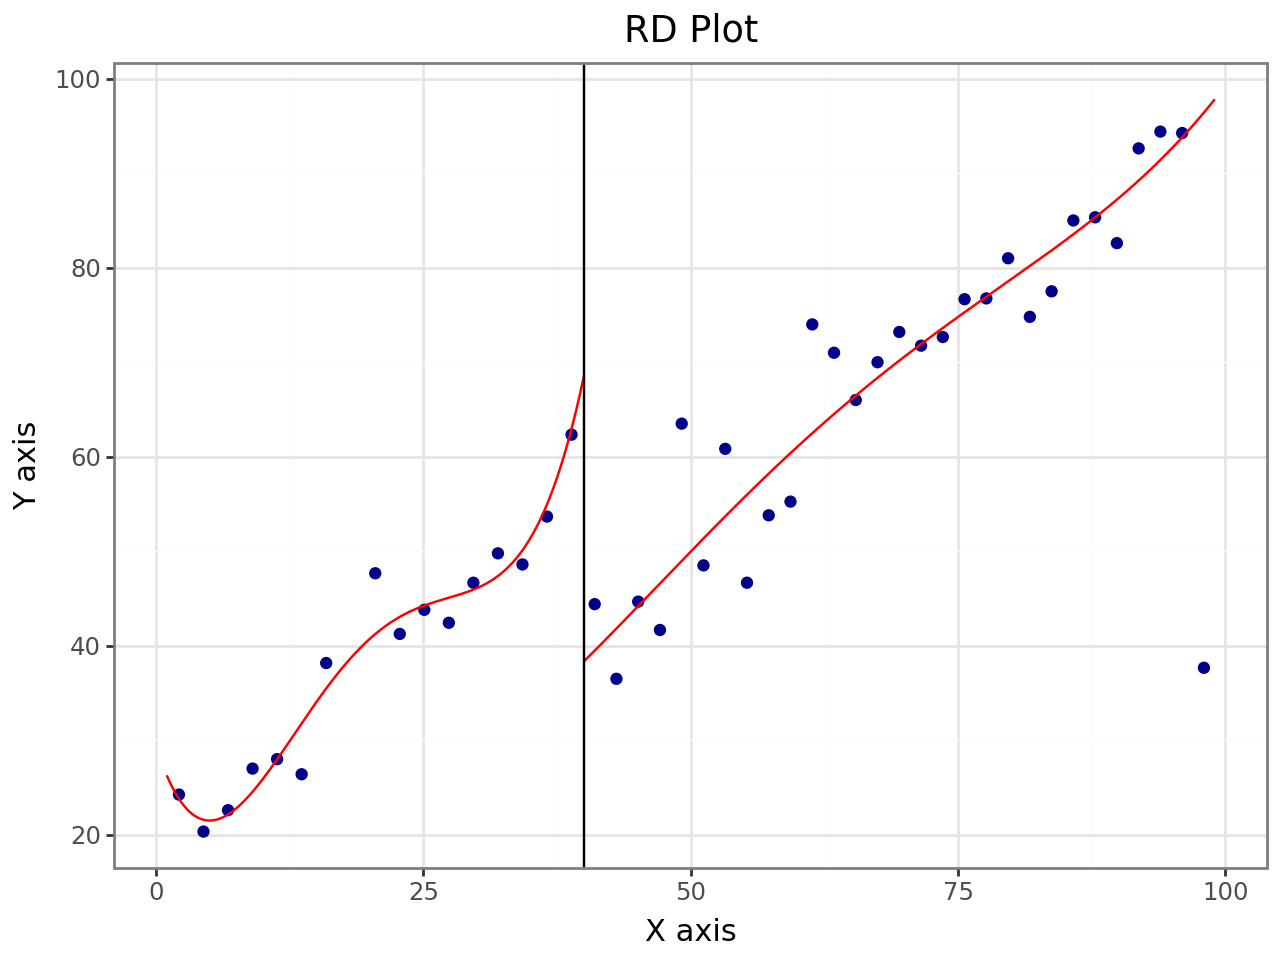

Call: rdplot
Number of Observations:                   200
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations            87        113
Number of Effective Obs           87        113
Bandwith poly. fit (h)            39         59
Number of bins scale               1          1
Bins Selected                     17         29
Average Bin Length             2.279      2.034
Median Bin Length              2.294      2.034
IMSE-optimal bins                9.0        9.0
Mimicking Variance bins         17.0       29.0

Relative to IMSE-optimal:
Implied scale                  1.889      3.222
WIMSE variance weight          0.129      0.029
WIMSE bias weight              0.871      0.971


In [81]:
rdrobust.rdplot(final_score, mid_score, c=40)

#### プラセボテスト  

In [86]:
rdrobust.rdrobust(final_score, mid_score, c=50)

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                   200
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           109         91
Number of Unique Obs.             46         42
Number of Effective Obs.          22         21
Bandwidth Estimation          10.315     10.315
Bandwidth Bias                19.223     19.223
rho (h/b)                      0.537      0.537

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.046   14.433    0.003   9.974e-01  [-28.241, 28.334]
Robust     

係数が0.046と推定されたことに加え、p値が有意水準よりも大きく、カットオフ値が50点の場合では因果効果がないことが分かったので、40点付近における補講を受けた生徒と受けてない生徒の期末テストの点数の差がたまたまでないことが考察できる  